# MLPClassifier

## Imports and custom functions

First, we import libraries, arrays and list we are going to use for this section.

We also redefine a custom function `display_classification_reports_confusion_matrices()` used after GridSearch to display classification report and confusion matrix overall, but also by customer class to assess predictive power for each customer class. `custom_format()` is used to reformat gridsearch results and improve readability.

In [1]:
import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.metrics import (accuracy_score, make_scorer, f1_score, 
                             precision_score, recall_score, 
                             classification_report, ConfusionMatrixDisplay,
                             average_precision_score)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler                    

In [2]:
def display_classification_reports_confusion_matrices(y_pred):
    """
    Takes predictions array as input and display classificaiton report overall and then
    Confusion matrices by customer class (rfm_label) that has been previously one hot encoded
    """
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(wspace=0.8)

    # Plots standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    disp1 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, ax=ax1)
    disp1.ax_.set_xticklabels(class_names, rotation=90)
    disp1.im_.colorbar.remove()

    # Plots normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    disp2 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize="true", display_labels=class_names, ax=ax2)
    disp2.ax_.set_xticklabels(class_names, rotation=90)
    disp2.im_.colorbar.remove()

    # Get classification report
    print(classification_report(y_test, y_pred, output_dict=False, zero_division=1))
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    # Get precision, recall, f1 from report dict
    precision = round(report['weighted avg']['precision'], 2)
    recall = round(report['weighted avg']['recall'], 2)
    f1 = round(report['weighted avg']['f1-score'], 2)
    
    # Format title
    title_formatted = f"Overall Confusion Matrices\nprecision={precision} recall={recall} f1={f1}"
    
    fig.suptitle(title_formatted, y=1.005)
    plt.show()
    
    # OHE columns matching our rfm_labels
    labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

    # Find column indices corresponding to OHE rfm_label columns
    label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

    # Iterate over each OHE rfm_label
    for i, label in enumerate(labels_of_interest):    
        # Find column position of OHE rfm_label
        label_index = label_indices[i]

        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)

        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        
        # Select corresponding rows of y_test and y_pred
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        # Restrict our class_names to only classes in subset
        # VIP can only become 5 values, other 6.
        classes = np.unique(y_test_subset)
        class_names_subset = [class_names[label] for label in classes if label in class_labels]

        fig, axs = plt.subplots(1, 2, figsize=(9, 4))

        # Plots standard confusion matrix
        axs[0].set_title("Confusion Matrix (counts)")
        disp1 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, display_labels=class_names_subset, ax=axs[0])
        disp1.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp1.im_.colorbar.remove()

        # Plots normalized confusion matrix
        axs[1].set_title("Confusion Matrix (ratios)")
        disp2 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, normalize="true", display_labels=class_names_subset, ax=axs[1])
        disp2.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp2.im_.colorbar.remove()

        # Get classification report
        report = classification_report(y_test_subset, y_pred_subset, output_dict=True, zero_division=1)
        # Get precision, recall, f1 from report dict
        precision = round(report['weighted avg']['precision'], 2)
        recall = round(report['weighted avg']['recall'], 2)
        f1 = round(report['weighted avg']['f1-score'], 2)
        # Format title
        title_formatted = f"{label}\nprecision={precision} recall={recall} f1={f1}"
        
        # Set figure title to label of interest
        fig.subplots_adjust(wspace=0.8)
        fig.suptitle(title_formatted, y=1.005)
        plt.show()

In [3]:
# Custom formatting for cv_results
pd.options.display.max_columns = None

def custom_format(value, col_name):
    if col_name.startswith('param_'):
        return value
    elif 'time' in col_name:
        return round(value, 0)
    elif 'mean' in col_name:
        return round(value, 3)
    elif 'std' in col_name:
        return round(value, 4)
    else:
        return value

Now, we load train and test set and also outliers arrays that can be used in outlier removal.

In [4]:
class_labels = [0, 1, 2, 3, 4]
class_names = ['Sleeping Dog', 'Low Value Customers', 'Sleeping Beauty', 'Good Customers', 'VIP']
colors = ['red', 'orange', 'purple', 'blue', 'green']

# Load test set from pickle file
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
X_test, y_test = testset['X_test'], testset['y_test']

# Load train set from pickle file
with open('trainset_base.pkl', 'rb') as f:
    trainset = pickle.load(f)
X_train, y_train = trainset['X_train'], trainset['y_train']

with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
    
# Load dictionary containing all outliers array
with open("outliers.pkl", "rb") as f:
    loaded_outliers_dict = pickle.load(f)

In [5]:
X_train_outliers_conservative = loaded_outliers_dict["conservative"]
X_train_outliers_aggressive = loaded_outliers_dict["aggressive"]
X_train_outliers_lof = loaded_outliers_dict["lof"]
X_train_outliers_iforest = loaded_outliers_dict["iforest"]

outlier_dict = {
    "aggressive": X_train_outliers_aggressive,
}

In [6]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(tol=1e-3)
model_file_name = 'MLP.csv'

We remove outliers using the following as we have seen better performance on other classifier using this method.

In [7]:
# Remove rows with outliers from X_train and y_train
outlier_mask = X_train_outliers_aggressive
X_train = X_train[outlier_mask != 1]
y_train = y_train[outlier_mask != 1]

Here, we use Robust Scaler to standardize our features before going into gridSearch.

In [8]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Initial parameters

We ran Multi-layer Perceptron classifier based on the following parameters at the start. From [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

- We test different hidden layer sizes, activation funciton, solver, alpha ... The goal was to see what results we got and what was useful or not.

```python
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200],
}
```

## Adaptations based on observations after running model

We simplify the following as we have seen better perfomance
- adam solver performs better so we keep it 
- Better performance with higher learning rate and similar performances with ['constant', 'invscaling', 'adaptive']. So we keep constant as it is the more simple.
    > ‘constant’ is a constant learning rate given by ‘learning_rate_init’.
- We add parameter 'learning_rate_init': [0.001, 0.01, 0.1] as increasing learning rate perfomed well on other classifier.
- Better perfomance with higher alphas, meaning with higher L2 regularization
- Default parameter here works better for hidden layer sizes. It is agreeing with our findings on Neural Network
    > default(100,) means if no value is provided for hidden_layer_sizes then default architecture will have one input layer, one hidden layer with 100 units and one output layer.
- Logistic activation perfoms better and this is a feedback we could also try out in Neural network. Overall all functions, tanh and relu, perfom relatively similarly.

In [9]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['constant'],
    'max_iter': [350],
}

# Use GridSearch to find best parameter
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=6,
    verbose=1,
    return_train_score=True,
    scoring={
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    },
    refit='f1'  
)

# Start timer
start_time = time.time()

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Print time taken to fit the model
print("Time taken to fit the model: {:.2f} seconds".format(elapsed_time))

# Print best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Evaluation on test data
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Time taken to fit the model: 64.08 seconds
Best parameters found by GridSearchCV: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 350, 'solver': 'adam'}
Accuracy on unseen test data: 56.92%


In [10]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_f1", ascending=False)

file_path = os.path.join('gs_results', model_file_name)
cv_results.to_csv(file_path, index=False)

# Get columns starting with 'param_'
param_columns = [col for col in cv_results.columns if col.startswith('param_')]

# Create a list of desired column names
desired_columns = [
    'mean_fit_time',
    'mean_test_f1', 'mean_train_f1',
    *param_columns, 
    'std_test_f1', 'std_train_f1',
    'mean_test_precision', 'mean_train_precision',
    'std_test_precision', 'std_train_precision',
    'mean_test_recall', 'mean_train_recall',
    'std_test_recall', 'std_train_recall',    
]

# Apply custom formatting function and select columns
cv_results = cv_results.apply(lambda col: col.apply(lambda value: custom_format(value, col.name)))
cv_results = cv_results[desired_columns]
cv_results.head(10)

,mean_fit_time,mean_test_f1,mean_train_f1,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,std_test_f1,std_train_f1,mean_test_precision,mean_train_precision,std_test_precision,std_train_precision,mean_test_recall,mean_train_recall,std_test_recall,std_train_recall
0,25.0,0.546,0.627,logistic,0.01,"(100,)",constant,350,adam,0.003,0.0034,0.545,0.626,0.0033,0.0041,0.552,0.631,0.0019,0.0031


## Results

### Classification report and Confusion matrices

We use our custom function to display confusion matrix and classications reports. Note that we don't extensively comment results here as they are from best model on validation f1 weighted score and we might end up chosing a different model with a better trade off between validation f1 weighted score and overfitting. We will do this in our results notebook, where we compile results from all our model.

              precision    recall  f1-score   support

           0       0.63      0.83      0.72      7803
           1       0.53      0.46      0.49      7823
           2       0.46      0.34      0.39      7800
           3       0.46      0.52      0.49      7740
           4       0.73      0.70      0.71      7834

    accuracy                           0.57     39000
   macro avg       0.56      0.57      0.56     39000
weighted avg       0.56      0.57      0.56     39000



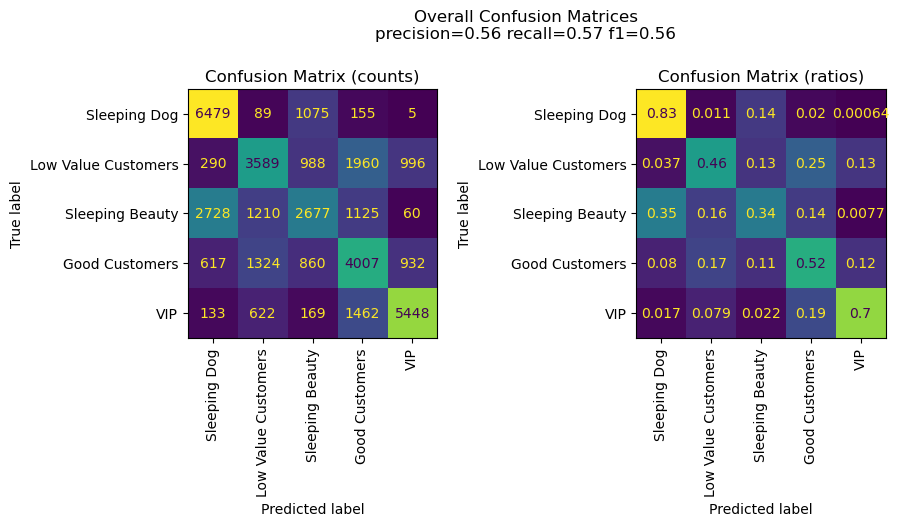

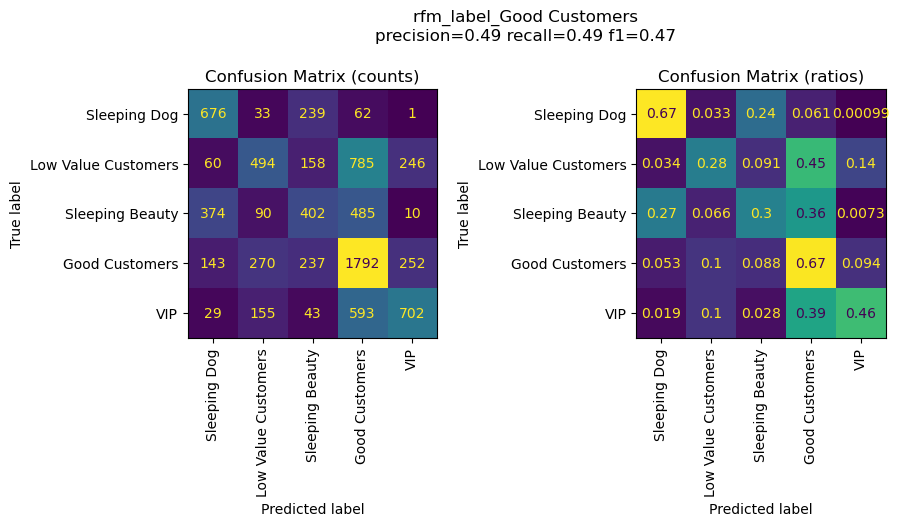

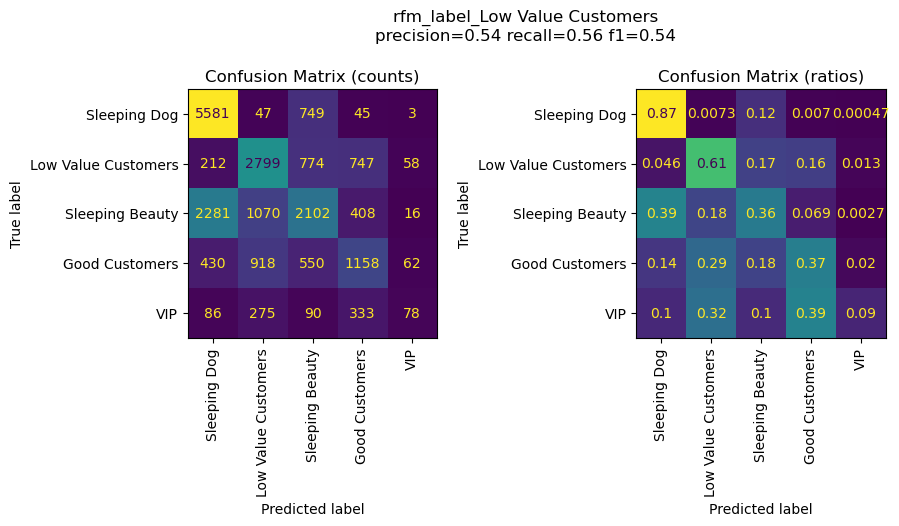

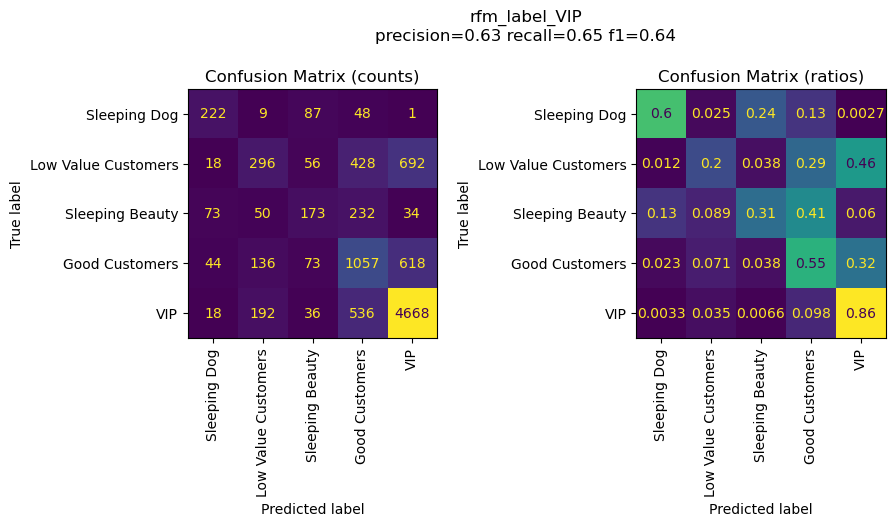

In [11]:
# Predict
y_pred = best_model.predict(X_test)
display_classification_reports_confusion_matrices(y_pred)